# Validating the model

We are now going to validate the model with the set we have reserved at the very beginning of this experiment

# Mounting google drive

In order to make it easy to read data from Google Drive, it can be mounted as a "local" unity. This encapsulates the connection to Google API and reduces the amount of coding that would be needed when interacting with Google API

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
import torch
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import imageio.v3 as iio

# Loading validation set index

We have saved an excel file as an index to the images we have reserved for validation.

In [3]:
base_folder = "/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project"
validation_set = pd.read_excel(os.path.join(base_folder, "validation_set.xlsx"))
validation_set.head()

,path,fruit,fresh,image_info,height,width,channel
0,/content/gdrive/MyDrive/08 CS670 Artificial In...,banana,False,"(408, 502, 3)",408,502,3
1,/content/gdrive/MyDrive/08 CS670 Artificial In...,banana,False,"(358, 356, 3)",358,356,3
2,/content/gdrive/MyDrive/08 CS670 Artificial In...,banana,False,"(392, 564, 3)",392,564,3
3,/content/gdrive/MyDrive/08 CS670 Artificial In...,banana,False,"(388, 572, 3)",388,572,3
4,/content/gdrive/MyDrive/08 CS670 Artificial In...,banana,True,"(446, 312, 3)",446,312,3


# Pre-processing

We need to apply the same standardization to validation set that we have applied to Train and Test set. For the pre-processing, we define again the same function used before

In [4]:
import cv2
def resize_and_pad(image, height = 512, width = 512, padColor = 0):
  h, w, c = image.shape
  size = (height, width)
  sh, sw = size

  # Remove alpha channel if the image has 4 channels
  if c > 3:
    image = image[:,:,:3]

  # interpolation method
  if h > sh or w > sw: # shrinking image
    interp = cv2.INTER_AREA
  else: # stretching image
    interp = cv2.INTER_CUBIC

  # aspect ratio of image
  aspect = w/h

  # compute scaling and pad sizing
  if aspect > 1: # horizontal image
    new_w = sw
    new_h = np.round(new_w/aspect).astype(int)
    pad_vert = (sh-new_h)/2
    pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
    pad_left, pad_right = 0, 0
  elif aspect < 1: # vertical image
    new_h = sh
    new_w = np.round(new_h*aspect).astype(int)
    pad_horz = (sw-new_w)/2
    pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
    pad_top, pad_bot = 0, 0
  else: # square image
    new_h, new_w = sh, sw
    pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

  # set pad color
  if len(image.shape) == 3 and not isinstance(padColor, (list, tuple,
      np.ndarray)): # color image but only one color provided
    padColor = [padColor]*3

  # Recalc the aspect ratio
  aspect = w/h
  scaled_img = cv2.resize(image, (new_w, new_h), interpolation=interp)
  scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)

  return scaled_img

# Loading saved model

We are going to load the model we have saved in the previous step/notebook in order to use it to predict the "new cases" (images from our validation set)

In [5]:
base_folder = "/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project"
model_folder = os.path.join(base_folder, "saved_model")
model = torch.load(os.path.join(model_folder, "fresh_banana_classification.pth"), map_location=torch.device('cpu'))

# Prediction function

Now we create a function that will receive the model and the image. It applies the pre-processing transformation and then loads the image on a tensor, applying the transformations we have applied when loading the train and test dataset.

It also adjusts the dimensions to match of what we have used to train and test (array of 3D images - therefore 4 dimensions).

After the transformations, it used the saved model to predict the image and outputs True if the prediction is for a fresh banana or False otherwise.

Is fresh? False


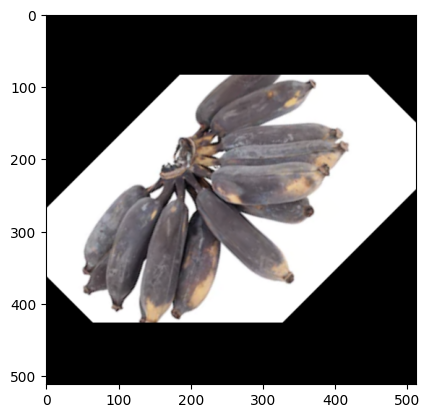

In [6]:
def is_fresh(model, image):
    from PIL import Image
    image = resize_and_pad(image)
    image = Image.fromarray(image)
    trans = transforms.Compose([
        transforms.Resize(255),
        transforms.ToTensor()
        ])
    input = trans(image)
    input = input.view(1, 3, 255, 255)
    output = model(input).argmax(axis=1)

    fresh = False
    if output[0].numpy() == 0:
        fresh = True

    return image, fresh

image = iio.imread(validation_set.iloc[100]["path"])
image, predicted_freshness = is_fresh(model, image)
print("Is fresh?", predicted_freshness)
plt.imshow(image)

# Check Validation set performance

We first define a function that gets the path, loads the image and calls the "is_fresh" function created abovem, returning True (fresh) or False (not fresh).

This function will be called by the apply method of the Pandas DataFrame we loaded with the index for the validation set

In [7]:
def validation_performance_check(path, model):
    image = iio.imread(path)
    image, predicted_freshness = is_fresh(model, image)
    return predicted_freshness


validation_set["predicted_freshness"] = validation_set["path"].apply(
    lambda x: validation_performance_check(
        x,
        model
    )
)

In [8]:
validation_set["true_label"] = np.where(validation_set["fresh"], "Fresh", "Not Fresh")
validation_set["predicted_label"] = np.where(validation_set["predicted_freshness"], "Fresh", "Not Fresh")
validation_set.head()

,path,fruit,fresh,image_info,height,width,channel,predicted_freshness,true_label,predicted_label
0,/content/gdrive/MyDrive/08 CS670 Artificial In...,banana,False,"(408, 502, 3)",408,502,3,False,Not Fresh,Not Fresh
1,/content/gdrive/MyDrive/08 CS670 Artificial In...,banana,False,"(358, 356, 3)",358,356,3,False,Not Fresh,Not Fresh
2,/content/gdrive/MyDrive/08 CS670 Artificial In...,banana,False,"(392, 564, 3)",392,564,3,False,Not Fresh,Not Fresh
3,/content/gdrive/MyDrive/08 CS670 Artificial In...,banana,False,"(388, 572, 3)",388,572,3,False,Not Fresh,Not Fresh
4,/content/gdrive/MyDrive/08 CS670 Artificial In...,banana,True,"(446, 312, 3)",446,312,3,True,Fresh,Fresh


In [9]:
validation_set.groupby(["true_label", "predicted_label"])["path"].count()

true_label  predicted_label
Fresh       Fresh              301
Not Fresh   Not Fresh          420
Name: path, dtype: int64

Now let's print the confusion matrix for the validation set

Text(0.5, 23.52222222222222, '\n\nAccuracy = 1.000\nPrecision = 1.000\nRecall = 1.000\nF1 Score = 1.000')

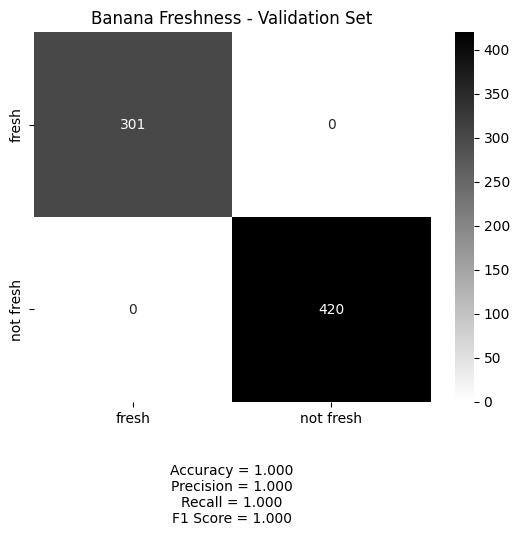

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(validation_set["true_label"], validation_set["predicted_label"])
sns.heatmap(cm, annot=True, fmt=".0f", cmap="binary",
            xticklabels = ["fresh", "not fresh"], yticklabels = ["fresh", "not fresh"])

# Metrics for Binary Confusion Matrices
accuracy  = np.trace(cm) / float(np.sum(cm))
precision = cm[1,1] / sum(cm[:,1])
recall    = cm[1,1] / sum(cm[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\n\nAccuracy = {:0.3f}\nPrecision = {:0.3f}\nRecall = {:0.3f}\nF1 Score = {:0.3f}".format(
    accuracy, precision, recall, f1_score)

plt.title(f"Banana Freshness - Validation Set")
plt.xlabel(stats_text)